In [219]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [220]:
def check_if_inside(point, bbox):
    bx0, by0, bx1, by1 = bbox
    x, y = point
    return (bx0 <= x <= bx1) and (by0 <= y <= by1)

In [221]:
tracking_bbox = pd.read_csv("track_04_30_18h_18.csv")
#true_points = pd.read_csv("tagged2min_04_30_18h_18.csv")
true_points = pd.read_csv("interpolated2min_04_30_18h_18.csv")


## ograniczanie danych

#### do obszaru zainteresowania na czerwono

In [222]:
main_area = [(0,720), (75, 288), (166,243), (1015,200), (1082, 241),
(1207, 512), (1065, 720)]
top_area = [(972, 390), (710, 310), (1135, 116), (1205, 161)]
bottom_area = [(1,661),(377,450),(807, 589),(640,719), (0,720)]
left_area = [(397,450),(591,337), (0,149), (1,293)]
right_area = [(755,598),(971,390), (1270, 505), (1259,684)]

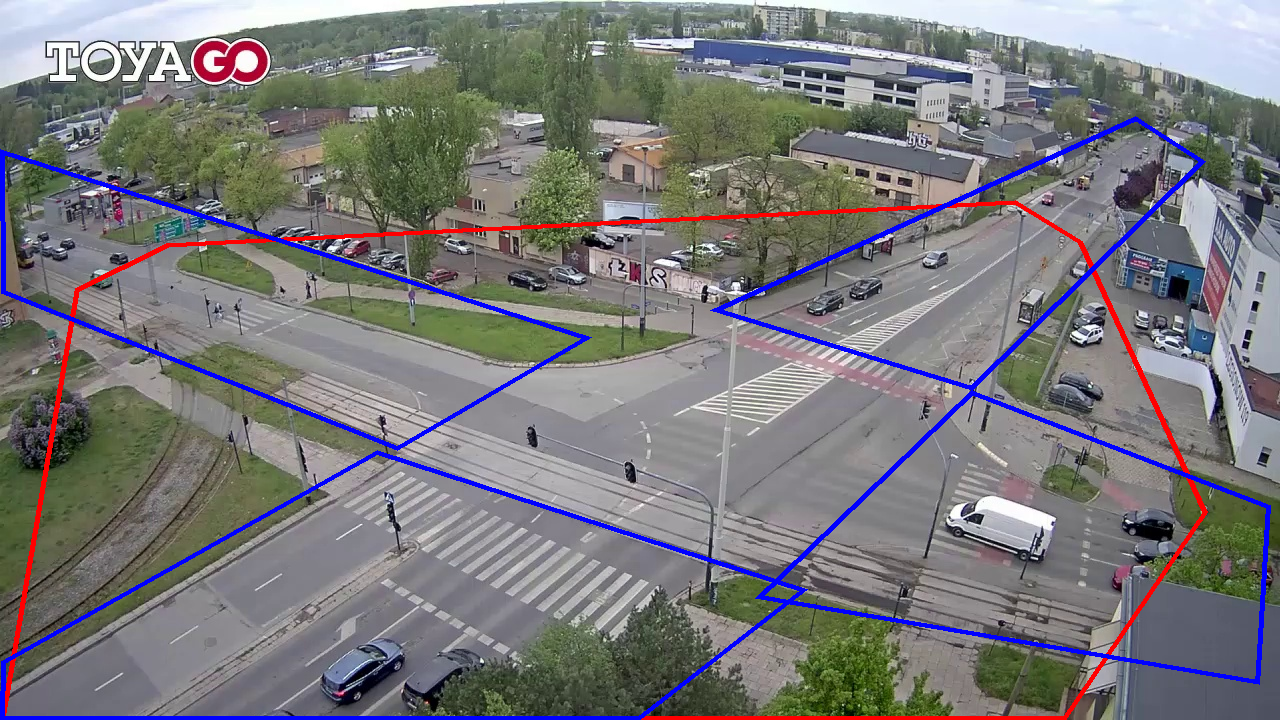

In [223]:
img = Image.open("reference.jpg")
img1 = ImageDraw.Draw(img)   
img1.polygon(main_area, outline ="red", width=5) 
img1.polygon(bottom_area, outline ="blue", width=5) 
img1.polygon(top_area, outline ="blue", width=5) 
img1.polygon(left_area, outline ="blue", width=5) 
img1.polygon(right_area, outline ="blue", width=5) 
img

$$ta+(1-t)b = (c_x, \cdot)$$

$$b+t(a-b) = (c_x, \cdot)$$

$$t^\ast = \frac{c_x-b_x}{a_x-b_x}, \ t^\ast(a-b) + b > c_y$$

In [224]:
def is_inner(px,py, polygon=main_area, verbose=False):
    points = polygon + [polygon[0]]
    counter = 0
    for a,b in zip(points, points[1:]):
        ax, ay = a
        bx, by = b
        ax, ay, bx, by = ax + 0.1, ay + 0.1, bx + 0.1, by + 0.1
        t = (px - bx)/(ax - bx)
        if 0 <= t < 1 and t * (ay - by) + by >= py:
            counter += 1
        if verbose:
            print(a, b, t)
    if verbose:
        print(counter)
    return (counter % 2) != 0
        

In [87]:
#####
#####  TAKES TRUE POINTS ONLY FROM INSIDE THE AREA OF INTEREST
#####

true_points = true_points[true_points.apply(lambda row: is_inner(row["x"], row["y"]), axis=1)]

#### do pierwszych dwóch minut

In [88]:
#####
#####  TAKES ONLY FRAMES FROM THE FIRST TWO MINUTES
#####

true_points = true_points[true_points["frame"] <= 30*60*2]
tracking_bbox = tracking_bbox[tracking_bbox["frame"] <= 30*60*2]

In [225]:
tracking_bbox['x'] = (tracking_bbox['x0'] + tracking_bbox['x1'])/2
tracking_bbox['y'] = (tracking_bbox['y0'] + tracking_bbox['y1'])/2

In [226]:
directions = []
for label, data in tracking_bbox.groupby("label"):
    for name, area in [("L", left_area), ("R", right_area), ("B", bottom_area), ("T", top_area)]:
        data[f"{name}"] = data.apply(lambda row: is_inner(row["x"], row["y"], area), axis=1)
    path_type = "".join([t for t, b in data[["L","R","B","T"]].any().items() if b])
    directions.append((label, path_type))
directions = pd.DataFrame(directions, columns = ["label", "path type"])

In [227]:
first_frame = tracking_bbox[["label", "frame"]][tracking_bbox["detected"] == 1].groupby("label").min().rename(columns={"frame": "first frame"})
last_frame = tracking_bbox[["label", "frame"]][tracking_bbox["detected"] == 1].groupby("label").max()
frame_range = first_frame
frame_range["last frame"] = last_frame
frame_range.reset_index()

,label,first frame,last frame
0,1,0,1316
1,2,0,2515
2,3,0,361
3,4,97,1537
4,6,170,393
...,...,...,...
2118,2492,112623,112914
2119,2493,112668,112706
2120,2494,112684,112914
2121,2495,112815,112817


In [228]:
tracking_bbox[tracking_bbox["x"]<0]

,x0,y0,x1,y1,label,detected,frame,x,y
9440,0,184,-6,204,36,0,865,-3.0,194.0
9452,0,180,-14,200,36,0,866,-7.0,190.0
9464,0,176,-22,196,36,0,867,-11.0,186.0
9476,0,172,-30,192,36,0,868,-15.0,182.0
10517,0,0,-5,-20,40,0,964,-2.5,-10.0
...,...,...,...,...,...,...,...,...,...
1003523,0,721,-47,720,2444,0,110969,-23.5,720.5
1003532,0,721,-51,720,2444,0,110970,-25.5,720.5
1003540,0,720,-55,720,2444,0,110971,-27.5,720.0
1003548,0,719,-59,720,2444,0,110972,-29.5,719.5


[]

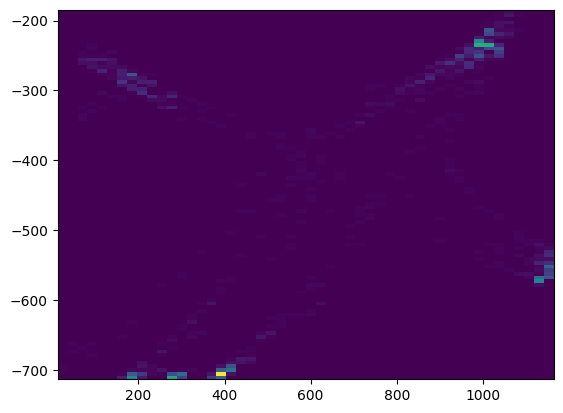

In [229]:
_tmp = tracking_bbox[tracking_bbox["detected"] == 1].merge(frame_range, left_on=["label","frame"],
                    right_on=["label", "first frame"])[["x","y"]]
plt.hist2d(_tmp["x"], -_tmp["y"], bins=(50,100))
[]

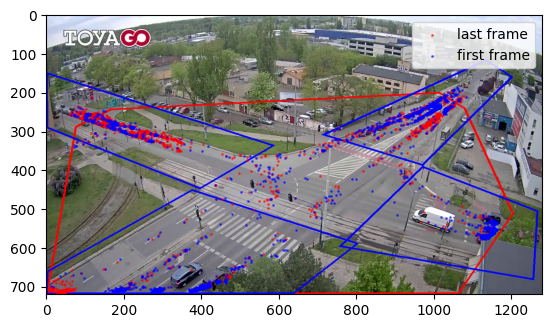

In [230]:
plt.imshow(img)
last_frames = tracking_bbox[tracking_bbox["detected"] == 1].merge(frame_range, left_on=["label","frame"],
                    right_on=["label", "last frame"]).drop(columns=["last frame", "first frame"])
plt.scatter(last_frames["x"], last_frames["y"], s=1, color="red", label="last frame", alpha=0.5)
first_frames = tracking_bbox[tracking_bbox["detected"] == 1].merge(frame_range, left_on=["label","frame"],
                    right_on=["label", "first frame"]).drop(columns=["last frame", "first frame"])#[["x","y"]]
plt.scatter(first_frames["x"], first_frames["y"], s=1, color="blue", label="first frame", alpha=0.5)
plt.legend()

In [231]:
segments = first_frames.merge(last_frames, on="label", suffixes=[" first", " last"])

In [234]:
segments["x first"]

0       1103.5
1        963.0
2        328.0
3       1154.0
4        412.5
         ...  
2118     996.0
2119     185.0
2120    1008.5
2121     931.5
2122     208.5
Name: x first, Length: 2123, dtype: float64

In [233]:
def _check(row, suffix=""):
    for name, area in [("L", left_area), ("R", right_area), ("B", bottom_area), ("T", top_area)]:
        if is_inner(row["x" + suffix], row["y" + suffix], area):
            return name
    return '0'
segments["type"] = segments.apply(lambda row: _check(row, suffix=" first"), axis=1)+ segments.apply(lambda row: _check(row, suffix=" last"), axis=1)

In [172]:
import cv2

In [200]:
[x for x in dir(cv2) if "Video" in x]

['VideoCapture', 'VideoWriter', 'VideoWriter_fourcc']

In [248]:
segments[segments["frame last"] < (54*60+21)*30]

,x0 first,y0 first,x1 first,y1 first,label,detected first,frame first,x first,y first,x0 last,y0 last,x1 last,y1 last,detected last,frame last,x last,y last,type
0,1073,501,1134,537,1,1,0,1103.5,519.0,902,399,946,440,1,1316,924.0,419.5,R0
1,951,253,975,272,2,1,0,963.0,262.5,23,708,66,720,1,2515,44.5,714.0,TB
2,199,575,457,717,3,1,0,328.0,646.0,484,389,659,584,1,361,571.5,486.5,B0
3,1135,541,1173,568,4,1,97,1154.0,554.5,68,242,87,256,1,1537,77.5,249.0,RL
4,380,552,445,592,6,1,170,412.5,572.0,207,295,234,316,1,393,220.5,305.5,BL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,255,694,324,719,2234,1,97393,289.5,706.5,235,290,271,309,1,97678,253.0,299.5,BL
1905,157,697,227,719,2235,1,97405,192.0,708.0,249,294,277,315,1,97733,263.0,304.5,BL
1906,250,698,318,719,2236,1,97463,284.0,708.5,317,312,358,336,1,97737,337.5,324.0,BL
1907,161,693,228,719,2237,1,97467,194.5,706.0,323,337,362,362,1,97734,342.5,349.5,BL


In [243]:
_tmp = segments[segments["type"].str.match("([^0])(?!(0|\\1))")][["label"]]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

width, height = 1280, 720
fps = 30
out = cv2.VideoWriter("E:\\street_data\\check_output.mp4", fourcc, 
                      fps, (width, height))

cap = cv2.VideoCapture('E:\\street_data\\output_04_30_18h_18.mp4')

for frame_id, data in tracking_bbox.merge(_tmp, on="label").groupby("frame"):
        ret, frame = cap.read()
        if frame_id %3 == 0:
            for _, row in data.iterrows():
                if row["detected"] == 1:
                    color = (0, 255, 0)
                else:
                    color = (0, 255, 255)
                frame = cv2.rectangle(frame, (int(row["x0"]), int(row["y0"])),
                                     (int(row["x1"]), int(row["y1"])), color)
                frame = cv2.putText(frame, str(row["label"]), 
                                    (int(row["x0"]), int(row["y0"])),
                                   cv2.FONT_HERSHEY_COMPLEX, 0.5, color)
            out.write(frame)
        #if frame_id > 30*30:
        #    break
out.release()
cap.release()

In [240]:
out.release()

In [144]:
segments[~segments["type"].str.contains("0")]["type"].value_counts()

TT    372
LL    310
BL    258
BT    257
TB    195
RL    173
TL    146
BB    138
RR     83
RT     32
RB     13
Name: type, dtype: int64

In [122]:
segments["type"].value_counts()

TT    372
LL    310
BL    258
BT    257
TB    195
RL    173
TL    146
BB    138
RR     83
00     62
RT     32
B0     23
0L     22
0T     14
RB     13
T0     12
R0      7
0B      6
Name: type, dtype: int64

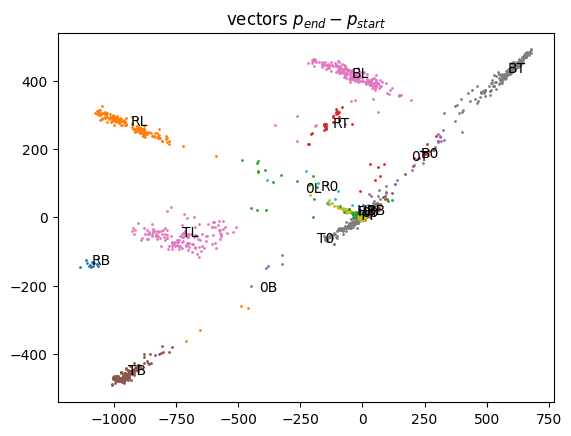

In [140]:
for seg_type, data in segments.groupby("type"):
    xs = data["x last"] - data["x first"]
    ys = data["y last"] - data["y first"]
    plt.scatter(xs, -ys, s=1)
    plt.annotate(seg_type, (xs.mean(), -ys.mean()), color="black")
plt.title("vectors $p_{end}-p_{start}$")    
plt.scatter([0],[0])
#plt.legend()
#plt.plot([-200,-200,200,200,-200],[200,-200,-200,200,200], color="red")

[]

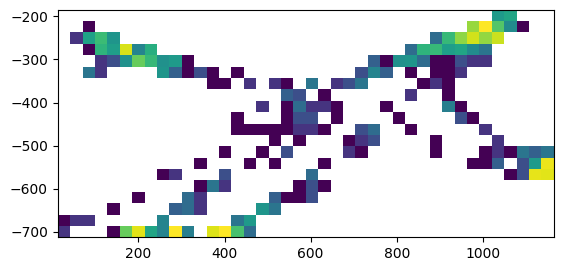

In [81]:
import matplotlib as mpl
import matplotlib.colors as colors
plt.imshow(img)
_tmp = tracking_bbox[tracking_bbox["detected"] == 1].merge(frame_range, left_on=["label","frame"],
                    right_on=["label", "first frame"])[["x","y"]]
plt.hist2d(_tmp["x"], -_tmp["y"], bins=(40,20), norm=colors.LogNorm(1,100))
[]

In [12]:
directions["path type"].value_counts()

BT    462
T     403
L     343
LB    260
LR    177
B     153
LT    151
R      82
RT     36
       34
RB     22
Name: path type, dtype: int64